### Predictive power of dimensionless features 
The transport of nanomaterials is difficult to predict. Using our developed machine learning tools, let's investigate if prediction is more powerful when we seperate the parameters than if we arrange the parameters as dimensionless ratios. 


In [37]:
# Let's import a bunch of packages
%matplotlib inline
import multiprocessing
import numpy as np
multiprocessing.cpu_count()
from helperFunctions import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import cross_validation
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
import matplotlib
import matplotlib.pyplot as plt
from biokit.viz import corrplot
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (8,6)

In [38]:
# locate the csv database
path = './transportData.csv'

# Import the csv as a dataframe.
data = pd.DataFrame.from_csv(path, header=0, sep=',', 
                             index_col=0, parse_dates=True, encoding=None,
                               tupleize_cols=False, infer_datetime_format=False)

    # List of features:
    # ['ObsRPShape', 'Poros', 'Darcy', 'ConcIn', 'PvIn', 'pH', 'IonStr',
    # 'SaltType', 'ColumnLWRatio', 'PartDensity', 'PartIEP', 'pHIEPDist',
    # 'PartZeta', 'CollecZeta', 'PartDiam', 'CollecDiam', 'PartCollSizeRatio',
    # 'Coating', 'ConcHA', 'TypeNOM', 'Hamaker', 'Dispersivity', 'NanoSize',
    # 'mbEffluent', 'mbRetained', 'mbEffluent_norm', 'mbRetained_norm']

In [39]:
# Not all the features are sufficient to support ML (our database is small anyway), 
# so let's drop some features. This consistutes the first drop round.
featuresToDrop = ['Hamaker','Dispersivity','NanoSize','pHIEPDist',
                  'PartCollSizeRatio','ColumnLWRatio',
                  'mbEffluent', 'mbRetained','mbEffluent_norm']
data = data.drop(featuresToDrop,1)

In [40]:
# create the calculated data fields:
data['tempKelvin'] = 298.15 # the temperature is always assumed to be 25 degrees.
data['relPermValue'] = data.apply(relPermittivity,axis=1) # Calculate the rel permittivity 
data['debyeLength'] = data.apply(debyeLength,axis=1) # Calculate the debye length
data['pecletNumber'] = data.apply(pecletNumber,axis=1)
data['aspectRatio'] = data.PartDiam/data.CollecDiam
data['zetaRatio'] = data.PartZeta/data.CollecZeta
data['pHIepRatio'] = data.pH/data.PartIEP


In [41]:
# factorize the remaining training data fields
data['Coating'] = data['Coating'].factorize()[0]
data['SaltType'] = data['Coating'].factorize()[0]
data['NMId'] = data['NMId'].factorize()[0]



In [42]:
# Do not include any experiments which have null values.
data = data.dropna()

In [43]:
# Set the target data fields. In this case, the 'ObsRPShape' and the 'mbRetained_norm' 
# (i.e., retained fration, RF).
targetDataRPShape = data['ObsRPShape'].factorize()[0] # convert text to numeric values
targetDataRPShapeUniqueList = list(set(data['ObsRPShape'].unique()))
targetDataRF = data.mbRetained_norm

In [44]:
# Drop the fields that are subordinate to the calculated fields (i.e., the ones 
# wrapped up in the dimensionless numbers(e.g., salttype and pH are in debyelength).
data = data.drop(['ObsRPShape', # target value (to be predicted)
                  'mbRetained_norm', # target value (to be predicted)
                  'Darcy', # included in peclet number
                  'ObsRPShape', # target value (to be predicted)
                  'relPermValue', # perfectly correlated wiht material and include in Debye
                  'tempKelvin', # assumed to be the same for each experiment (also in Debye)
                  'PartZeta', # included in dimensionless ratio of zetas
                  'PartIEP', # included in dimensionless ratio of pH to IEP
                  'PartDiam', # included in dimensionless aspect ratio
                  'CollecDiam', # included in dimensionless aspect ratio
                  'CollecZeta',# included in dimensionless aspect ratio
                  'IonStr', # included in Debye Length
                  'SaltType',# included in Debye Length
                  'pH'# included in dimensionless ratio of pH to IEP
                 ],1)

print list(data) # print out the remaining data field headers

['NMId', 'Poros', 'ConcIn', 'PvIn', 'PartDensity', 'Coating', 'ConcHA', 'TypeNOM', 'debyeLength', 'pecletNumber', 'aspectRatio', 'zetaRatio', 'pHIepRatio']


Computing correlation


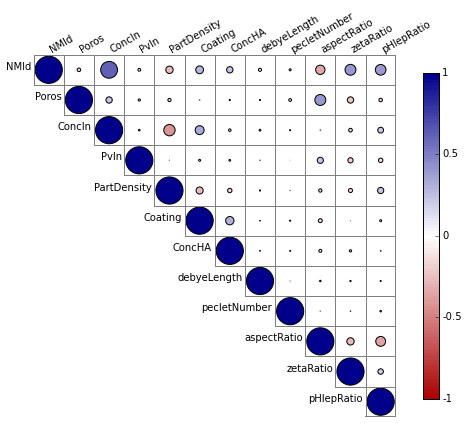

In [45]:
# Let's check to see how correlated our variables are. print data.corr() 
# to inspect values. Make sure to install biokit dependencies with requirements.txt
# https://pypi.python.org/pypi/biokit/0.0.5

c = corrplot.Corrplot(data)
c.plot(upper='circle',fontsize = 10)



### Now that we've verified that our variables are not heavily correlated, we can develop an empirical prediction model that uses the nano transport experimental conditions to predict the outcomes. 
